In [1]:
import os
import sys

# Set working directory to project root
os.chdir(r"C:\Users\User\Documents\cs599_deepLearning\harmful-ingredient-detector")
print("✅ Now in:", os.getcwd())

# Add root to Python path
sys.path.append(os.getcwd())



✅ Now in: C:\Users\User\Documents\cs599_deepLearning\harmful-ingredient-detector


In [2]:
from data.load_beauty_data import get_beauty_dataset
from preprocessing.clean_and_label import load_ingredient_blacklist, label_dataframe

df = get_beauty_dataset()
harmful_set = load_ingredient_blacklist()
df = label_dataframe(df, harmful_set)

# Rename columns for Hugging Face Dataset
df = df[['ingredients_text', 'label']].rename(columns={'ingredients_text': 'text'})


In [ ]:
import os

print("Working directory:", os.getcwd())
print("Contents of ./data:")
print(os.listdir("data"))


In [3]:
from datasets import Dataset
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

hf_dataset = Dataset.from_pandas(df)

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True)

hf_dataset = hf_dataset.map(tokenize, batched=True)
hf_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])


Map:   0%|          | 0/14496 [00:00<?, ? examples/s]

## Step 4: Split and Load

In [4]:
hf_dataset = hf_dataset.train_test_split(test_size=0.2, seed=42)
train_ds = hf_dataset['train']
test_ds = hf_dataset['test']


## Step 5: Load DistilBERT for Sequence Classification

In [5]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Step 6: Train the Model

In [ ]:
import transformers
print(transformers.__version__)

In [ ]:
from transformers import TrainingArguments
print(TrainingArguments.__module__)


In [ ]:
from transformers import TrainingArguments
help(TrainingArguments)


In [6]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds
)

trainer.train()


Epoch,Training Loss,Validation Loss
1,0.159200,0.084186
2,0.012300,0.055087
3,0.001200,0.054059


TrainOutput(global_step=2175, training_loss=0.06383927045261552, metrics={'train_runtime': 35273.5493, 'train_samples_per_second': 0.986, 'train_steps_per_second': 0.062, 'total_flos': 4608275864444928.0, 'train_loss': 0.06383927045261552, 'epoch': 3.0})

In [7]:
import pandas as pd

# Convert logs to DataFrame
log_df = pd.DataFrame(trainer.state.log_history)

# Preview (optional)
print(log_df)

# Save to CSV
log_df.to_csv("results/distilbert_training_log.csv", index=False)


       loss  grad_norm  learning_rate     epoch  step  eval_loss  \
0    0.4096   1.232111   4.979310e-05  0.013793    10        NaN   
1    0.2313   0.624803   4.956322e-05  0.027586    20        NaN   
2    0.3001   3.277108   4.933333e-05  0.041379    30        NaN   
3    0.2222   1.285676   4.910345e-05  0.055172    40        NaN   
4    0.3404   4.801582   4.887356e-05  0.068966    50        NaN   
..      ...        ...            ...       ...   ...        ...   
216  0.0295   0.012944   5.977011e-07  2.965517  2150        NaN   
217  0.0117   0.008537   3.678161e-07  2.979310  2160        NaN   
218  0.0012   0.043430   1.379310e-07  2.993103  2170        NaN   
219     NaN        NaN            NaN  3.000000  2175   0.054059   
220     NaN        NaN            NaN  3.000000  2175        NaN   

     eval_runtime  eval_samples_per_second  eval_steps_per_second  \
0             NaN                      NaN                    NaN   
1             NaN                      NaN   

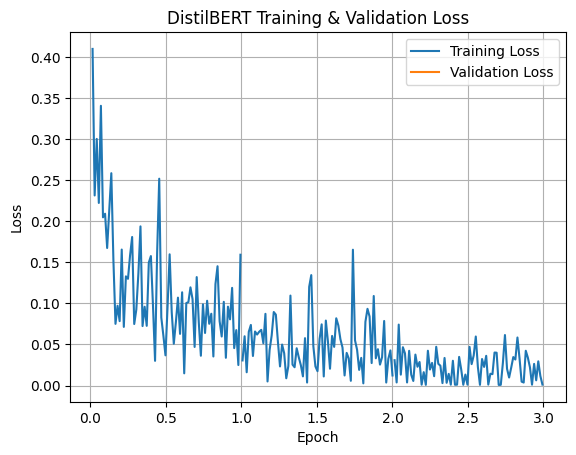

In [8]:
import matplotlib.pyplot as plt

plt.plot(log_df["epoch"], log_df["loss"], label="Training Loss")
if "eval_loss" in log_df.columns:
    plt.plot(log_df["epoch"], log_df["eval_loss"], label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("DistilBERT Training & Validation Loss")
plt.grid(True)
plt.savefig("plots/distilbert_loss_curve.png", dpi=300)
plt.show()


In [9]:
trainer.save_model("models/distilbert_harmful_classifier")  # saves model + tokenizer
tokenizer.save_pretrained("models/distilbert_harmful_classifier")


('models/distilbert_harmful_classifier\\tokenizer_config.json',
 'models/distilbert_harmful_classifier\\special_tokens_map.json',
 'models/distilbert_harmful_classifier\\vocab.txt',
 'models/distilbert_harmful_classifier\\added_tokens.json',
 'models/distilbert_harmful_classifier\\tokenizer.json')

In [10]:
predictions = trainer.predict(test_ds)
y_pred = predictions.predictions.argmax(axis=1)
y_true = predictions.label_ids



In [11]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=["Safe", "Harmful"])
print(report)

# Save to file
with open("results/distilbert_classification_report.txt", "w") as f:
    f.write(report)


              precision    recall  f1-score   support

        Safe       0.97      0.94      0.96       494
     Harmful       0.99      0.99      0.99      2406

    accuracy                           0.99      2900
   macro avg       0.98      0.97      0.97      2900
weighted avg       0.99      0.99      0.99      2900



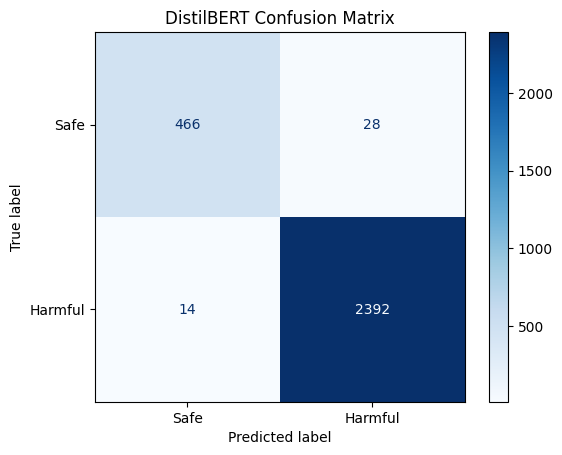

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Safe", "Harmful"])
disp.plot(cmap="Blues", values_format="d")
plt.title("DistilBERT Confusion Matrix")
plt.savefig("plots/distilbert_confusion_matrix.png", dpi=300)
plt.show()
